# Reinforcement
In this notebook, we are going to be focusing on the A2CAgent in the reinforcement agents module in PAI-Utils.

## Import Packages

In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython import display

from paiutils import neural_network as nn
from paiutils import reinforcement as rl
from paiutils import reinforcement_agents as ra


# see if using GPU and if so enable memory growth
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Create Environment
We are going to be using the MountainCar-v0 environment. For more information on this environment, click [this](https://github.com/openai/gym/wiki/MountainCar-v0).

In [2]:
genv = gym.make('MountainCar-v0')
max_steps = genv._max_episode_steps
print(max_steps)
print(genv.observation_space, genv.action_space)

class GymWrapper(rl.GymWrapper):
    def render(self):
        """Render for Jupyter Notebooks.
        """
        x = self.genv.render(mode='rgb_array')
        if 'img' in self.__dict__:
            self.img.set_data(x)
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            self.img = plt.imshow(x)

env = GymWrapper(genv)

200
Box(-1.2000000476837158, 0.6000000238418579, (2,), float32) Discrete(3)


## A2CAgent

### Create Models

In [3]:
inputs = keras.layers.Input(shape=env.state_shape)
x = nn.dense(64)(inputs)
x = nn.dense(64)(x)
outputs = nn.dense(env.action_size, activation='softmax',
                   batch_norm=False)(x)
amodel = keras.Model(inputs=inputs,
                     outputs=outputs)
amodel.compile(optimizer=keras.optimizers.Adam(.001),
                loss='mse')
amodel.summary()

inputs = keras.layers.Input(shape=env.state_shape)
x = nn.dense(64)(inputs)
x = nn.dense(64)(x)
outputs = keras.layers.Dense(1)(x)

cmodel = keras.Model(inputs=inputs,
                     outputs=outputs)
cmodel.compile(optimizer=keras.optimizers.Adam(.001),
               loss='mse')
cmodel.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                192       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 5,059
Trainable params: 4,803
Non-trainable params: 256
__________________________________________________

### Create Agent

In [4]:
discounted_rate = .99
lambda_rate = 0.95
agent = ra.A2CAgent(
    amodel, cmodel, discounted_rate,
    lambda_rate=lambda_rate,
    create_memory=lambda shape, dtype: rl.Memory(20000)
)

### Train the Agent

In [5]:
def end_episode_callback(episode, step, reward):
    global agent
    if reward > -150:
        # Check if agent may be able
        # to solve the environment
        old_playing_data = agent.playing_data
        agent.set_playing_data(training=False,
                               memorizing=False)
        result = env.play_episodes(
            agent, 10, max_steps,
            verbose=False, episode_verbose=False,
            render=False
        )
        print(f'Validate Results: {result}')
        if result >= -110:
            agent.save(
                save_dir, note=f'A2C_{episode}_{result}'
            )
        agent.playing_data = old_playing_data
        if result >= -100:
            # end early
            return True

# No warmup needed
#agent.set_playing_data(memorizing=True, verbose=True)
#env.play_episodes(agent, 100, max_steps, random=True,
#                  verbose=True, episode_verbose=False,
#                  render=False)

agent.set_playing_data(
    training=True, memorizing=True,
    batch_size=16, mini_batch=1024,
    epochs=1, repeat=5,
    entropy_coef=0,
    verbose=False
)
save_dir = ''
num_episodes = 500
result = env.play_episodes(
    agent, num_episodes, max_steps,
    verbose=True, episode_verbose=False,
    render=False,
    end_episode_callback=end_episode_callback
)
agent.save(save_dir, note=f'A2C_{ndx}_{result}')

Save Loop: 0
Time: 15:59:01 - Episode: 1 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -200.0 - Average Total Reward: -200.0 - Memory Size: 200
Time: 15:59:01 - Episode: 2 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -200.0 - Average Total Reward: -200.0 - Memory Size: 400
Time: 15:59:02 - Episode: 3 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -200.0 - Average Total Reward: -200.0 - Memory Size: 600
Time: 15:59:03 - Episode: 4 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -200.0 - Average Total Reward: -200.0 - Memory Size: 800
Time: 15:59:04 - Episode: 5 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -200.0 - Average Total Reward: -200.0 - Memory Size: 1000
Time: 15:59:05 - Episode: 6 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -200.0 - Average Total Reward: -200.0 - Memory Size: 1200
Time: 15:59:06 - Episode: 7 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -200.0 - Average Total Reward: -200.0 - Memory S

Time: 16:00:04 - Episode: 58 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -200.0 - Average Total Reward: -200.0 - Memory Size: 11600
Time: 16:00:05 - Episode: 59 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -200.0 - Average Total Reward: -200.0 - Memory Size: 11800
Time: 16:00:07 - Episode: 60 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -200.0 - Average Total Reward: -200.0 - Memory Size: 12000
Time: 16:00:08 - Episode: 61 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -200.0 - Average Total Reward: -200.0 - Memory Size: 12200
Time: 16:00:09 - Episode: 62 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -200.0 - Average Total Reward: -200.0 - Memory Size: 12400
Time: 16:00:10 - Episode: 63 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -200.0 - Average Total Reward: -200.0 - Memory Size: 12600
Time: 16:00:12 - Episode: 64 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -200.0 - Average Total Reward: -200.0 - Memo

Validate Results: -195.1
Time: 16:01:35 - Episode: 112 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -129.0 - Average Total Reward: -194.70535714285714 - Memory Size: 20000
Time: 16:01:37 - Episode: 113 - Steps: 135 - Total Reward: -135.0 - Best Total Reward: -129.0 - Average Total Reward: -194.1769911504425 - Memory Size: 20000
Validate Results: -165.2
Time: 16:01:40 - Episode: 114 - Steps: 171 - Total Reward: -171.0 - Best Total Reward: -129.0 - Average Total Reward: -193.97368421052633 - Memory Size: 20000
Time: 16:01:42 - Episode: 115 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -129.0 - Average Total Reward: -194.02608695652174 - Memory Size: 20000
Time: 16:01:43 - Episode: 116 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -129.0 - Average Total Reward: -194.07758620689654 - Memory Size: 20000
Time: 16:01:45 - Episode: 117 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -129.0 - Average Total Reward: -194.12820512820514 - Memory Size: 200

Time: 16:03:20 - Episode: 161 - Steps: 90 - Total Reward: -90.0 - Best Total Reward: -90.0 - Average Total Reward: -185.1304347826087 - Memory Size: 20000
Validate Results: -146.2
Time: 16:03:24 - Episode: 162 - Steps: 161 - Total Reward: -161.0 - Best Total Reward: -90.0 - Average Total Reward: -184.9814814814815 - Memory Size: 20000
Time: 16:03:25 - Episode: 163 - Steps: 118 - Total Reward: -118.0 - Best Total Reward: -90.0 - Average Total Reward: -184.57055214723925 - Memory Size: 20000
Validate Results: -119.4
Time: 16:03:28 - Episode: 164 - Steps: 120 - Total Reward: -120.0 - Best Total Reward: -90.0 - Average Total Reward: -184.1768292682927 - Memory Size: 20000
Validate Results: -128.4
Time: 16:03:31 - Episode: 165 - Steps: 93 - Total Reward: -93.0 - Best Total Reward: -90.0 - Average Total Reward: -183.62424242424242 - Memory Size: 20000
Validate Results: -140.4
Time: 16:03:34 - Episode: 166 - Steps: 87 - Total Reward: -87.0 - Best Total Reward: -87.0 - Average Total Reward: -1

Validate Results: -144.2
Time: 16:05:30 - Episode: 208 - Steps: 138 - Total Reward: -138.0 - Best Total Reward: -87.0 - Average Total Reward: -174.90384615384616 - Memory Size: 20000
Validate Results: -144.2
Time: 16:05:33 - Episode: 209 - Steps: 147 - Total Reward: -147.0 - Best Total Reward: -87.0 - Average Total Reward: -174.77033492822966 - Memory Size: 20000
Validate Results: -142.3
Time: 16:05:36 - Episode: 210 - Steps: 138 - Total Reward: -138.0 - Best Total Reward: -87.0 - Average Total Reward: -174.5952380952381 - Memory Size: 20000
Validate Results: -147.6
Time: 16:05:40 - Episode: 211 - Steps: 146 - Total Reward: -146.0 - Best Total Reward: -87.0 - Average Total Reward: -174.45971563981044 - Memory Size: 20000
Validate Results: -142.9
Time: 16:05:43 - Episode: 212 - Steps: 143 - Total Reward: -143.0 - Best Total Reward: -87.0 - Average Total Reward: -174.31132075471697 - Memory Size: 20000
Validate Results: -141.6
Time: 16:05:46 - Episode: 213 - Steps: 141 - Total Reward: -1

Time: 16:07:21 - Episode: 257 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -85.0 - Average Total Reward: -171.8171206225681 - Memory Size: 20000
Time: 16:07:22 - Episode: 258 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -85.0 - Average Total Reward: -171.92635658914728 - Memory Size: 20000
Time: 16:07:24 - Episode: 259 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -85.0 - Average Total Reward: -172.03474903474904 - Memory Size: 20000
Time: 16:07:25 - Episode: 260 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -85.0 - Average Total Reward: -172.1423076923077 - Memory Size: 20000
Time: 16:07:27 - Episode: 261 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -85.0 - Average Total Reward: -172.24904214559388 - Memory Size: 20000
Time: 16:07:28 - Episode: 262 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -85.0 - Average Total Reward: -172.35496183206106 - Memory Size: 20000
Time: 16:07:29 - Episode: 263 - Steps: 200 - Total Rew

Validate Results: -143.6
Time: 16:08:43 - Episode: 309 - Steps: 128 - Total Reward: -128.0 - Best Total Reward: -85.0 - Average Total Reward: -175.1747572815534 - Memory Size: 20000
Validate Results: -151.3
Time: 16:08:46 - Episode: 310 - Steps: 123 - Total Reward: -123.0 - Best Total Reward: -85.0 - Average Total Reward: -175.00645161290322 - Memory Size: 20000
Validate Results: -127.1
Time: 16:08:50 - Episode: 311 - Steps: 114 - Total Reward: -114.0 - Best Total Reward: -85.0 - Average Total Reward: -174.81028938906752 - Memory Size: 20000
Validate Results: -134.8
Time: 16:08:53 - Episode: 312 - Steps: 200 - Total Reward: -200.0 - Best Total Reward: -85.0 - Average Total Reward: -174.89102564102564 - Memory Size: 20000
Time: 16:08:54 - Episode: 313 - Steps: 115 - Total Reward: -115.0 - Best Total Reward: -85.0 - Average Total Reward: -174.6996805111821 - Memory Size: 20000
Validate Results: -161.2
Time: 16:08:58 - Episode: 314 - Steps: 119 - Total Reward: -119.0 - Best Total Reward: 

Time: 16:10:50 - Episode: 356 - Steps: 174 - Total Reward: -174.0 - Best Total Reward: -85.0 - Average Total Reward: -171.5056179775281 - Memory Size: 20000
Time: 16:10:52 - Episode: 357 - Steps: 146 - Total Reward: -146.0 - Best Total Reward: -85.0 - Average Total Reward: -171.43417366946778 - Memory Size: 20000
Validate Results: -143.9
Time: 16:10:55 - Episode: 358 - Steps: 99 - Total Reward: -99.0 - Best Total Reward: -85.0 - Average Total Reward: -171.231843575419 - Memory Size: 20000
Validate Results: -137.7
Time: 16:10:58 - Episode: 359 - Steps: 96 - Total Reward: -96.0 - Best Total Reward: -85.0 - Average Total Reward: -171.02228412256267 - Memory Size: 20000
Validate Results: -146.6
Time: 16:11:01 - Episode: 360 - Steps: 146 - Total Reward: -146.0 - Best Total Reward: -85.0 - Average Total Reward: -170.95277777777778 - Memory Size: 20000
Validate Results: -157.4
Time: 16:11:05 - Episode: 361 - Steps: 84 - Total Reward: -84.0 - Best Total Reward: -84.0 - Average Total Reward: -1

Time: 16:12:43 - Episode: 405 - Steps: 137 - Total Reward: -137.0 - Best Total Reward: -83.0 - Average Total Reward: -169.0172839506173 - Memory Size: 20000
Validate Results: -141.4
Time: 16:12:47 - Episode: 406 - Steps: 160 - Total Reward: -160.0 - Best Total Reward: -83.0 - Average Total Reward: -168.99507389162562 - Memory Size: 20000
Time: 16:12:48 - Episode: 407 - Steps: 160 - Total Reward: -160.0 - Best Total Reward: -83.0 - Average Total Reward: -168.97297297297297 - Memory Size: 20000
Time: 16:12:49 - Episode: 408 - Steps: 124 - Total Reward: -124.0 - Best Total Reward: -83.0 - Average Total Reward: -168.86274509803923 - Memory Size: 20000
Validate Results: -125.0
Time: 16:12:52 - Episode: 409 - Steps: 94 - Total Reward: -94.0 - Best Total Reward: -83.0 - Average Total Reward: -168.679706601467 - Memory Size: 20000
Validate Results: -102.0
Time: 16:12:55 - Episode: 410 - Steps: 107 - Total Reward: -107.0 - Best Total Reward: -83.0 - Average Total Reward: -168.52926829268293 - M

Validate Results: -104.0
Time: 16:14:44 - Episode: 453 - Steps: 106 - Total Reward: -106.0 - Best Total Reward: -83.0 - Average Total Reward: -166.04415011037528 - Memory Size: 20000
Validate Results: -104.5
Time: 16:14:47 - Episode: 454 - Steps: 104 - Total Reward: -104.0 - Best Total Reward: -83.0 - Average Total Reward: -165.90748898678413 - Memory Size: 20000
Validate Results: -114.6
Time: 16:14:50 - Episode: 455 - Steps: 107 - Total Reward: -107.0 - Best Total Reward: -83.0 - Average Total Reward: -165.77802197802197 - Memory Size: 20000
Validate Results: -107.1
Time: 16:14:53 - Episode: 456 - Steps: 89 - Total Reward: -89.0 - Best Total Reward: -83.0 - Average Total Reward: -165.609649122807 - Memory Size: 20000
Validate Results: -96.1


### Load the Best Save

In [5]:
agent.load('trained_a2cagent_mountaincarv0', load_data=False)

'A2C_224_-100.1'

### Test the Agent

-109.0


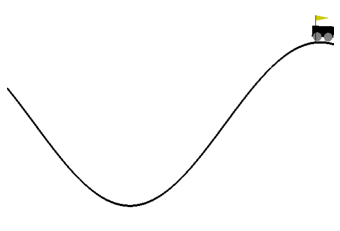

In [6]:
agent.set_playing_data(training=False,
                       memorizing=False)
step, total_reward = env.play_episode(
    agent, max_steps,
    verbose=False, render=True
)
print(total_reward)

#### Solved?
The MountainCar environment is considered solved if we get an average reward of -110.0 over 100 consecutive episodes.

In [7]:
num_episodes = 100
agent.set_playing_data(training=False,
                       memorizing=False)
result = env.play_episodes(
    agent, num_episodes, max_steps,
    verbose=True, episode_verbose=False,
    render=False
)
print(f'Solved: {result >= -110}')

Time: 16:25:44 - Episode: 1 - Steps: 105 - Total Reward: -105.0 - Best Total Reward: -105.0 - Average Total Reward: -105.0 - Memory Size: 0
Time: 16:25:44 - Episode: 2 - Steps: 112 - Total Reward: -112.0 - Best Total Reward: -105.0 - Average Total Reward: -108.5 - Memory Size: 0
Time: 16:25:44 - Episode: 3 - Steps: 105 - Total Reward: -105.0 - Best Total Reward: -105.0 - Average Total Reward: -107.33333333333333 - Memory Size: 0
Time: 16:25:44 - Episode: 4 - Steps: 113 - Total Reward: -113.0 - Best Total Reward: -105.0 - Average Total Reward: -108.75 - Memory Size: 0
Time: 16:25:44 - Episode: 5 - Steps: 110 - Total Reward: -110.0 - Best Total Reward: -105.0 - Average Total Reward: -109.0 - Memory Size: 0
Time: 16:25:44 - Episode: 6 - Steps: 109 - Total Reward: -109.0 - Best Total Reward: -105.0 - Average Total Reward: -109.0 - Memory Size: 0
Time: 16:25:45 - Episode: 7 - Steps: 114 - Total Reward: -114.0 - Best Total Reward: -105.0 - Average Total Reward: -109.71428571428571 - Memory S

Time: 16:25:52 - Episode: 57 - Steps: 84 - Total Reward: -84.0 - Best Total Reward: -83.0 - Average Total Reward: -105.57894736842105 - Memory Size: 0
Time: 16:25:52 - Episode: 58 - Steps: 86 - Total Reward: -86.0 - Best Total Reward: -83.0 - Average Total Reward: -105.24137931034483 - Memory Size: 0
Time: 16:25:52 - Episode: 59 - Steps: 110 - Total Reward: -110.0 - Best Total Reward: -83.0 - Average Total Reward: -105.32203389830508 - Memory Size: 0
Time: 16:25:52 - Episode: 60 - Steps: 112 - Total Reward: -112.0 - Best Total Reward: -83.0 - Average Total Reward: -105.43333333333334 - Memory Size: 0
Time: 16:25:53 - Episode: 61 - Steps: 111 - Total Reward: -111.0 - Best Total Reward: -83.0 - Average Total Reward: -105.52459016393442 - Memory Size: 0
Time: 16:25:53 - Episode: 62 - Steps: 87 - Total Reward: -87.0 - Best Total Reward: -83.0 - Average Total Reward: -105.2258064516129 - Memory Size: 0
Time: 16:25:53 - Episode: 63 - Steps: 112 - Total Reward: -112.0 - Best Total Reward: -83

## Gameplay
[![Gameplay of the A2C Agent](http://img.youtube.com/vi/V2eJdqS8T9Q/0.jpg)](https://www.youtube.com/watch?v=V2eJdqS8T9Q)